This is the implementation for drug_drug interaction discovery. This implementation is suitable for large-scale datasets, but requires more memory space.

The code for modeling is cloned from https://github.com/aalto-ics-kepaco/comboFM.git

1. run `git clone https://github.com/aalto-ics-kepaco/comboFM.git`.

2. run `cd comboFM`.

You have to download the dataset from https://zenodo.org/record/4135059 (around 420.1 MB zip file). 

Move the folder `comboFM_data/data` which contains several `csv` files to the `comboFM` folder.

3. Now you should have your data files under `comboFM/data/xxx.csv`.

4. run `mkdir my_experiments`.

You will have a new empty folder `comboFM/my_experiments`. Move this `drug_drug_interaction.ipynb` file to `comboFM/my_experiments/drug_drug_interaction.ipynb`.

Now you are ready to run the following codes. The training time is around 28 mins on a 12 core Intel(R) Xeon(R) Gold 6230R CPU @ 2.10GHz machine.

In [1]:
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr
from sys import argv
from utils import concatenate_features, standardize
from sklearn.ensemble import RandomForestRegressor


In [2]:
seed = 123 # Random seed
data_dir = "../data/" # you may need to set this by to your data_dir
experiment= "new_drug_combinations"

In [3]:
X1 = ("drug1__one-hot_encoding.csv",
"drug2__one-hot_encoding.csv",
"cell_lines__one-hot_encoding.csv",
"drug1_drug2_concentration__values.csv")

In [4]:
X1 = concatenate_features(data_dir, X1)

Reading file: drug1__one-hot_encoding.csv
Reading file: drug2__one-hot_encoding.csv
Reading file: cell_lines__one-hot_encoding.csv
Reading file: drug1_drug2_concentration__values.csv
... done!


In [5]:
X1[:,0:50]=X1[:,-2].reshape(555300,1)*X1[:,0:50]
X1[:,50:100]=X1[:,-1].reshape(555300,1)*X1[:,50:100]
X=np.concatenate([(X1[:,0:50]+X1[:,50:100]),X1[:,100:160]],axis=1)
X = np.concatenate((X, X), axis=0)
del X1

In [6]:
X.shape

(1110600, 110)

In [7]:
# Read responses
y  = np.loadtxt("../data/responses.csv", delimiter = ",", skiprows = 1)
y = np.concatenate((y, y), axis=0)

In [8]:
(np.concatenate([X,y.reshape(-1,1)],axis=1)[:555300,:]).shape

(555300, 111)

In [9]:
for outer_fold in [1]:
    te_idx = np.loadtxt('../cross-validation_folds/%s/test_idx_outer_fold-%d.txt'%(experiment, outer_fold)).astype(int)
    tr_idx = np.loadtxt('../cross-validation_folds/%s/train_idx_outer_fold-%d.txt'%(experiment, outer_fold)).astype(int)

    X_tr, X_te, y_tr, y_te = X[tr_idx,:], X[te_idx,:], y[tr_idx], y[te_idx]
#X_tr, X_te, y_tr, y_te = X[:500000,:], X[500000:,:], y[:500000], y[500000:]

    X_tr, X_te = standardize(X_tr, X_te, 0)
    n_trees, max_features = 512 , 0.5
    model = RandomForestRegressor(
                n_estimators = n_trees,
                max_features = max_features,
                random_state = seed,
                n_jobs = 12
            )

    # Train the model
    print(outer_fold)
    model.fit(X_tr, y_tr)
    y_pred_te = model.predict(X_te)
    RMSE = np.sqrt(mean_squared_error(y_te, y_pred_te))
    print(RMSE)
    RPearson = np.corrcoef(y_te, y_pred_te)[0,1]
    print(RPearson)
    RSpearman,_ = spearmanr(y_te, y_pred_te)
    print(RSpearman)

1
15.05465084729108
0.9424293381220985
0.8701381013117735


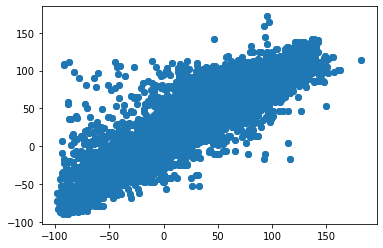

In [10]:
import matplotlib.pyplot as plt
plt.scatter(y_te,y_pred_te)

## Interaction Detection without UCB (implementation for large scale dataset)

In [11]:
from itertools import combinations
p = X_tr.shape[1]
def generate_comMat(p,h):
    combolist = list(combinations(range(p),2)) 
    comMat=np.zeros([4*int(p*(p-1)/2), p])
    for i in range(len(combolist)):
        comMat[i*4,combolist[i][0]] = 1
        comMat[i*4,combolist[i][1]] = 1
        comMat[i*4+1,combolist[i][0]] = 1
        comMat[i*4+1,combolist[i][1]] = -1
        comMat[i*4+2,combolist[i][0]] = -1
        comMat[i*4+2,combolist[i][1]] = 1
        comMat[i*4+3,combolist[i][0]] = -1
        comMat[i*4+3,combolist[i][1]] = -1
    return comMat*h
comMat = generate_comMat(p,0.8)

Hessian_vec = np.zeros(int(p*(p-1)/2))

## cal interaction strength for one sample.
for i in range(100):
    X_dup = np.tile(X_tr[i,:], (4*int(p*(p-1)/2), 1))+comMat
    cc = model.predict(X_dup).reshape(int(p*(p-1)/2),4)
    inter_temp = ((cc[:,0]-cc[:,1]-cc[:,2]+cc[:,3])**2)
    Hessian_vec = Hessian_vec + inter_temp
    if i%10 ==0:
        print("evaluated on ",i, " points")
# normalize
Hessian_vec = Hessian_vec/max(Hessian_vec)

evaluated on  0  points
evaluated on  10  points
evaluated on  20  points
evaluated on  30  points
evaluated on  40  points
evaluated on  50  points
evaluated on  60  points
evaluated on  70  points
evaluated on  80  points
evaluated on  90  points


In [12]:
%time
Hessian_mat=np.zeros([p,p])
combolist = list(combinations(range(p),2))
for i in range(len(combolist)):
    Hessian_mat[combolist[i][0],combolist[i][1]]=Hessian_vec[i]

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 14.1 µs


0.0


<IPython.core.display.Javascript object>


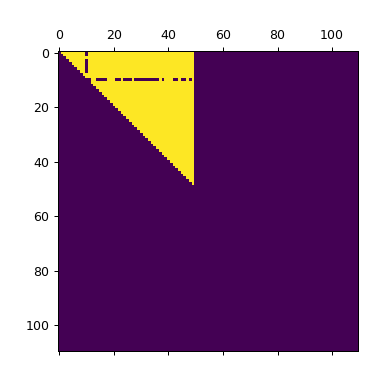

0.1


<IPython.core.display.Javascript object>


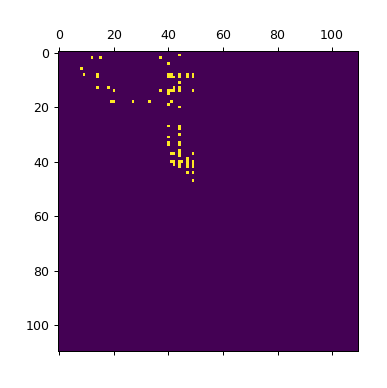

0.2


<IPython.core.display.Javascript object>


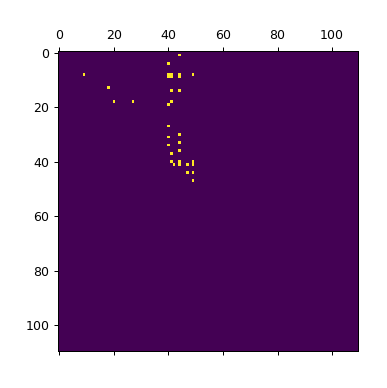

0.30000000000000004


<IPython.core.display.Javascript object>


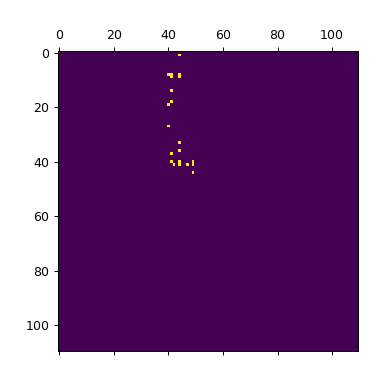

0.4


<IPython.core.display.Javascript object>


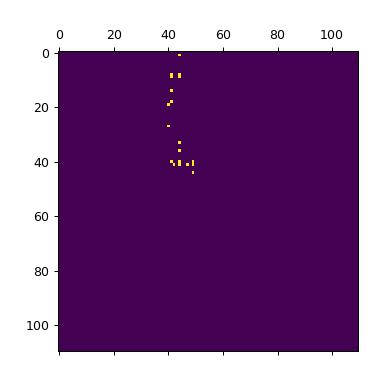

0.5


<IPython.core.display.Javascript object>


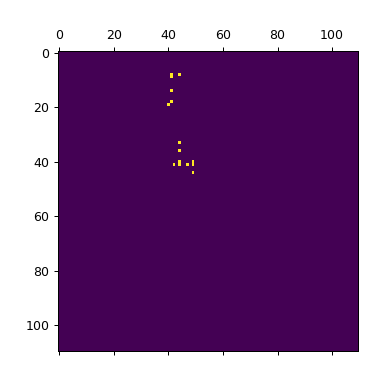

0.6000000000000001


<IPython.core.display.Javascript object>


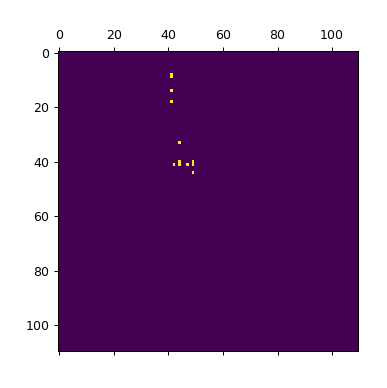

0.7000000000000001


<IPython.core.display.Javascript object>


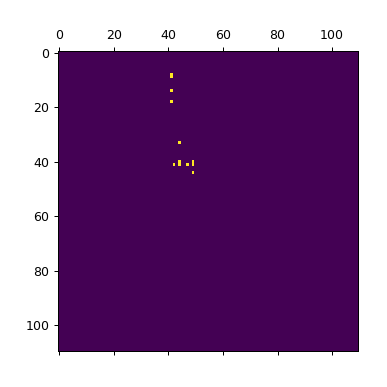

0.8


<IPython.core.display.Javascript object>


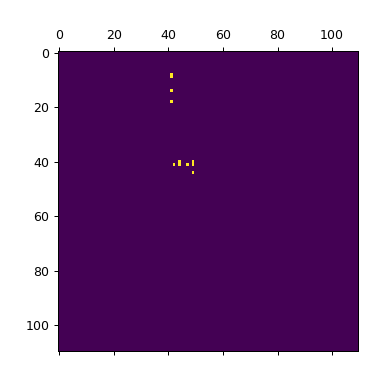

0.9


<IPython.core.display.Javascript object>


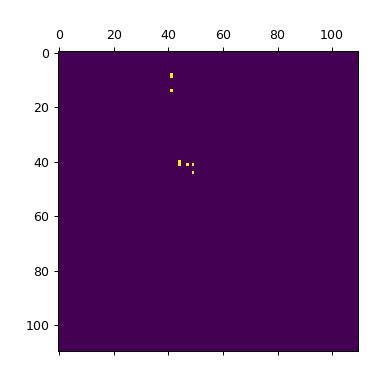

In [13]:
%matplotlib notebook
import matplotlib.pyplot as plt
for threshhold in np.arange(0,1,0.1):
    print(threshhold)
    plt.matshow((Hessian_mat)>threshhold)
#plt.matshow(Hessian_mat)

Detected interactions

In [14]:
import pandas as pd
df1 = pd.read_csv("../data/drug1__one-hot_encoding.csv")
df2 = pd.read_csv("../data/drug2__one-hot_encoding.csv")
print(df1.columns.values)
print(df2.columns.values)

['Drug1_Ifosfamide' 'Drug1_Amifostine' 'Drug1_Chlorambucil'
 'Drug1_Hydroxyurea' 'Drug1_Estramustine phosphate sodium'
 'Drug1_Exemestane' 'Drug1_Thiotepa' 'Drug1_Thalidomide'
 'Drug1_Thioguanine' 'Drug1_Gefitinib' 'Drug1_Sorafenib tosylate'
 'Drug1_Procarbazine hydrochloride' 'Drug1_Melphalan' 'Drug1_Ruxolitinib'
 'Drug1_Teniposide' 'Drug1_Oxaliplatin' 'Drug1_Pemetrexed Disodium'
 'Drug1_Fulvestrant' 'Drug1_Vinorelbine tartrate' 'Drug1_Crizotinib'
 'Drug1_Axitinib' 'Drug1_Valrubicin' 'Drug1_Dactinomycin'
 'Drug1_Romidepsin' 'Drug1_Carmustine' 'Drug1_Mitotane'
 'Drug1_Erlotinib hydrochloride' 'Drug1_Vandetanib' 'Drug1_Cladribine'
 'Drug1_Daunorubicin hydrochloride' 'Drug1_Vismodegib'
 'Drug1_Megestrol acetate' 'Drug1_Lenalidomide' 'Drug1_Tamoxifen citrate'
 'Drug1_Quinacrine hydrochloride' 'Drug1_Bortezomib'
 'Drug1_Vincristine sulfate' 'Drug1_Uracil mustard' 'Drug1_Dacarbazine'
 'Drug1_Lomustine' 'Drug1_Mitoxantrone' 'Drug1_Cytarabine hydrochloride'
 'Drug1_Arsenic trioxide' 'Drug1_Vi

In [15]:
import re
index = np.nonzero(Hessian_mat>0.2)
for i in range(len(index[0])):
    print((index[0][i])%50,"and" ,(index[1][i])%50 )
    print(re.findall(r"_.*$",df1.columns.values[(index[0][i])%50])[0][1:]+"; "+re.findall(r"_.*$",df1.columns.values[(index[1][i])%50])[0][1:])
    #print(df1.columns.values[(index[0][i])%50],"and",df2.columns.values[(index[1][i])%50])

1 and 44
Amifostine; Cabazitaxel
4 and 40
Estramustine phosphate sodium; Mitoxantrone
8 and 9
Thioguanine; Gefitinib
8 and 40
Thioguanine; Mitoxantrone
8 and 41
Thioguanine; Cytarabine hydrochloride
8 and 44
Thioguanine; Cabazitaxel
8 and 49
Thioguanine; Floxuridine
9 and 40
Gefitinib; Mitoxantrone
9 and 41
Gefitinib; Cytarabine hydrochloride
9 and 44
Gefitinib; Cabazitaxel
13 and 18
Ruxolitinib; Vinorelbine tartrate
14 and 41
Teniposide; Cytarabine hydrochloride
14 and 44
Teniposide; Cabazitaxel
18 and 20
Vinorelbine tartrate; Axitinib
18 and 27
Vinorelbine tartrate; Vandetanib
18 and 41
Vinorelbine tartrate; Cytarabine hydrochloride
19 and 40
Crizotinib; Mitoxantrone
27 and 40
Vandetanib; Mitoxantrone
30 and 44
Vismodegib; Cabazitaxel
31 and 40
Megestrol acetate; Mitoxantrone
33 and 44
Tamoxifen citrate; Cabazitaxel
34 and 40
Quinacrine hydrochloride; Mitoxantrone
36 and 44
Vincristine sulfate; Cabazitaxel
37 and 41
Uracil mustard; Cytarabine hydrochloride
40 and 41
Mitoxantrone; Cyt

<IPython.core.display.Javascript object>


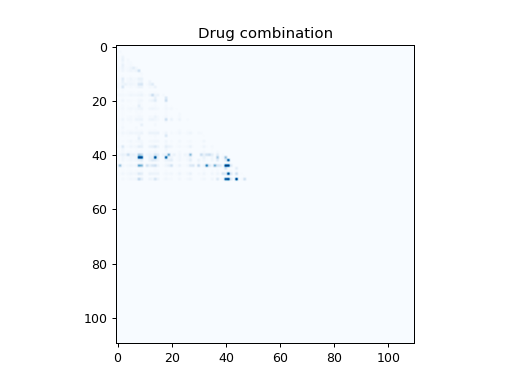

Text(0.5, 1.0, 'Drug combination')

In [16]:
fig, ax = plt.subplots()
im = ax.imshow(Hessian_mat.T,cmap=plt.cm.Blues)
ax.set_title("Drug combination")
#fig.savefig('druginteraction.pdf',bbox_inches='tight',dpi=fig.dpi,pad_inches=0.1)

In [17]:
from joblib import dump, load
dump(model, 'RF_drug_model.joblib') 
model = load('RF_drug_model.joblib') 

One can check the interactions in https://go.drugbank.com/interax/multi_search